C:\Users\y-kobayashi\Anaconda3\envs\rein-env\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


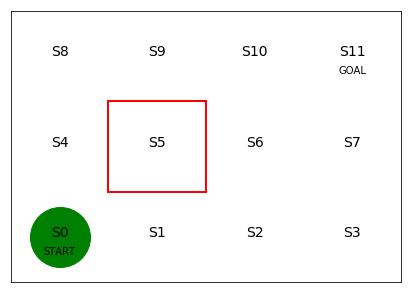

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(7,5))
ax = plt.gca()

plt.plot([1,1],[2,1],color='red', linewidth=2)
plt.plot([2,1],[2,2],color='red', linewidth=2)
plt.plot([2,2],[1,2],color='red', linewidth=2)
plt.plot([1,2],[1,1],color='red', linewidth=2)

plt.text(0.5, 0.5, 'S0', size=14, ha='center')
plt.text(1.5, 0.5, 'S1', size=14, ha='center')
plt.text(2.5, 0.5, 'S2', size=14, ha='center')
plt.text(3.5, 0.5, 'S3', size=14, ha='center')

plt.text(0.5, 1.5, 'S4', size=14, ha='center')
plt.text(1.5, 1.5, 'S5', size=14, ha='center')
plt.text(2.5, 1.5, 'S6', size=14, ha='center')
plt.text(3.5, 1.5, 'S7', size=14, ha='center')

plt.text(0.5, 2.5, 'S8', size=14, ha='center')
plt.text(1.5, 2.5, 'S9', size=14, ha='center')
plt.text(2.5, 2.5, 'S10', size=14, ha='center')
plt.text(3.5, 2.5, 'S11', size=14, ha='center')

plt.text(0.5, 0.3, 'START', ha='center')
plt.text(3.5, 2.3, 'GOAL', ha='center')

ax.set_xlim(0, 4)
ax.set_ylim(0, 3)

plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off',right='off', left='off', labelleft='off')

line, = ax.plot([0.5], [0.5], marker="o",color='g', markersize=60)



In [3]:
theta_0 = np.array([[1, 1, np.nan, np.nan], #S0
                    [np.nan, 1, np.nan, 1], #S1
                    [1, 1, np.nan, 1], #S2
                    [1, np.nan, np.nan, 1], #S3
                    [1, np.nan, 1, np.nan], #S4
                    [np.nan, np.nan, np.nan, np.nan], #S5
                    [1, 1, 1, np.nan], #S6
                    [1, np.nan, 1, 1], #S7
                    [np.nan, 1, 1, np.nan], #S8
                    [np.nan, 1, np.nan, 1], #S9
                    [np.nan, 1, 1, 1], #S10
                   ])
theta_0

array([[ 1.,  1., nan, nan],
       [nan,  1., nan,  1.],
       [ 1.,  1., nan,  1.],
       [ 1., nan, nan,  1.],
       [ 1., nan,  1., nan],
       [nan, nan, nan, nan],
       [ 1.,  1.,  1., nan],
       [ 1., nan,  1.,  1.],
       [nan,  1.,  1., nan],
       [nan,  1., nan,  1.],
       [nan,  1.,  1.,  1.]])

In [24]:
def simple_convert_into_pi_from_theta(theta):
    
    [m,n] = theta.shape
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :]/np.nansum(theta[i, :])
    
    pi = np.nan_to_num(pi)
    
    return pi


In [30]:
def get_action(s, Q, epsilon, pi_0):
    
    direction = ["up", "right", "down", "left"]
    
    if np.random.rand() < epsilon:
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        next_direction = direction[np.nanargmax(Q[s, :])]
    
    if next_direction == "up":
        action = 0
    if next_direction == "right":
        action = 1
    if next_direction == "down":
        action = 2
    if next_direction == "left":
        action = 3
    
    return action

def get_s_next(s, a):
    
    direction = ["up", "right", "down", "left"]
    next_action = direction[a]
    
    if next_action == "up":
        s_next = s + 4
    if next_action == "right":
        s_next = s + 1
    if next_action == "down":
        s_next = s - 4
    if next_action == "left":
        s_next = s - 1

    return s_next

In [51]:
from collections import deque 

class Memory:
    
    def __init__(self, max_size=5000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self):
        return self.buffer.pop()
    
    def len(self):
        return len(self.buffer)

In [50]:
def Q_learnings(s, a, r, s_next, Q):
    
    eta = 0.1
    gamma = 0.9
    
    if s_next == 11:
        Q[s,a] = Q[s,a] + eta*(r - Q[s,a])
    else:
        Q[s,a] = Q[s,a] + eta*(r + gamma*np.nanmax(Q[s_next,:]) - Q[s,a])    
    
    return Q

def Sarsa(s, a, r, s_next, a_next, Q):

    eta = 0.1
    gamma = 0.9
    
    if s_next ==11:
        Q[s, a] = Q[s, a] + eta*(r - Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta*(r + gamma*Q[s_next, a_next] - Q[s, a])
    
    return Q

def update_Q_montecarlo(Q, memory):
    
    eta = 0.5
    gamma = 0.9
    total_reward_t = 0
    
    while (memory.len() > 0):
        (s, a, r) = memory.sample()
        total_reward_t = gamma*total_reward_t
        
        Q[s,a] = Q[s,a] + eta*(r + total_reward_t - Q[s,a] )
        total_reward_t = total_reward_t + r
        
    return Q

In [59]:
def goal_maze_ret_s_a_Q(Q, epsilon, pi):
    
    s = 0
    a = a_next = get_action(s, Q, epsilon, pi)
    s_a_history = [[0, np.nan]]
    step =0
    
    while(1):
        
        a = a_next
        s_a_history[-1][1] = a
        s_next = get_s_next(s, a)
        s_a_history.append([s_next, np.nan])
        
        #print("step = {0}, a = {1}, s_next = {2}".format(step, a, s_next))
        
        if s_next==11:
            r=1
            a_next = np.nan
        elif s_next ==7:
            r=-1
            a_next = get_action(s_next, Q, epsilon, pi)
        elif s_next ==8:
            r=-0.1
            a_next = get_action(s_next, Q, epsilon, pi)
        else:
            r=0
            a_next = get_action(s_next, Q, epsilon, pi)
        
        #Q = Q_learnings(s, a, r, s_next, Q)
        Q = Sarsa(s, a, r, s_next, a_next, Q)
        
        if s_next==11:
            break
        else:
            s = s_next
        
        step +=1
    
    return [s_a_history, Q]

In [63]:
def goal_maze_memory(Q, epsilon, pi):
    
    s = 0
    
    step = 0
    memory = Memory(max_size=5000)
    
    
    while step<5000:
        
        a = get_action(s, Q, epsilon, pi)
        s_next = get_s_next(s, a)
        
        if s_next==11:
            r=1
        elif s_next==7:
            r=-10
        else:
            r=0
        
        memory.add((s, a, r))
        
        if s_next==11:
            break
        else:
            s = s_next
        
        step +=1
        
    return memory,step

#print(Q)
#q=Q
#for i in range(10):
#    q=goal_maze_ret_s_a_Q(Q, 0.1, 0.1, 0.9, pi_0)
#q

In [64]:
theta_0 = np.array([[1, 1, np.nan, np.nan], #S0
                    [np.nan, 1, np.nan, 1], #S1
                    [1, 1, np.nan, 1], #S2
                    [1, np.nan, np.nan, 1], #S3
                    [1, np.nan, 1, np.nan], #S4
                    [np.nan, np.nan, np.nan, np.nan], #S5
                    [1, 1, 1, np.nan], #S6
                    [1, np.nan, 1, 1], #S7
                    [np.nan, 1, 1, np.nan], #S8
                    [np.nan, 1, np.nan, 1], #S9
                    [np.nan, 1, 1, 1], #S10
                   ])
pi_0 = simple_convert_into_pi_from_theta(theta_0)
[a, b] = theta_0.shape
Q = np.random.rand(a, b)*theta_0*0.1

epsilon = 0.5


In [65]:
#[s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, pi_0)
#s_a_history

In [66]:
#Q-learning or Sarsa
v = np.nanmax(Q, axis=1)
is_continue = True
episode = 1

V =[]
V.append(np.nanmax(Q, axis=1))

while is_continue:
    
    print("エピソード：" + str(episode))
    epsilon = epsilon/2
    
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, pi_0)
    
    new_v = np.nanmax(Q, axis=1)
    print(np.sum(np.abs(new_v - v)))
    print(Q)
    v = new_v
    V.append(v)
    
    print("step : {0}".format(len(s_a_history)-1))
    
    episode = episode +1
    if episode >100:
        break



C:\Users\y-kobayashi\Anaconda3\envs\rein-env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: All-NaN slice encountered
  
C:\Users\y-kobayashi\Anaconda3\envs\rein-env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: All-NaN slice encountered
  import sys
C:\Users\y-kobayashi\Anaconda3\envs\rein-env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: All-NaN slice encountered
  app.launch_new_instance()


エピソード：1
nan
[[0.05180007 0.06798268        nan        nan]
 [       nan 0.08484654        nan 0.08760912]
 [0.09617938 0.05877863        nan 0.03651535]
 [0.09445168        nan        nan 0.00517517]
 [0.07083467        nan 0.02785018        nan]
 [       nan        nan        nan        nan]
 [0.03348783 0.01926509 0.01070723        nan]
 [0.06954382        nan 0.05161764 0.0216621 ]
 [       nan 0.04780106 0.01694593        nan]
 [       nan 0.03925309        nan 0.01656491]
 [       nan 0.12259689 0.06820383 0.03352702]]
step : 5
エピソード：2
nan
[[0.05180007 0.07047249        nan        nan]
 [       nan 0.08501803        nan 0.08284162]
 [0.08957534 0.05877863        nan 0.03651535]
 [0.09445168        nan        nan 0.00517517]
 [0.07083467        nan 0.02785018        nan]
 [       nan        nan        nan        nan]
 [0.04117277 0.01926509 0.01070723        nan]
 [0.06954382        nan 0.05161764 0.0216621 ]
 [       nan 0.04780106 0.01694593        nan]
 [       nan 0.03925309   

 [       nan 0.99980831 0.06820383 0.03352702]]
step : 5
エピソード：82
nan
[[0.05180007 0.6071715         nan        nan]
 [       nan 0.70749664        nan 0.07948248]
 [0.80288988 0.05877863        nan 0.03651535]
 [0.09445168        nan        nan 0.00517517]
 [0.07083467        nan 0.02785018        nan]
 [       nan        nan        nan        nan]
 [0.8984322  0.01926509 0.01070723        nan]
 [0.06954382        nan 0.05161764 0.0216621 ]
 [       nan 0.04780106 0.01694593        nan]
 [       nan 0.03925309        nan 0.01656491]
 [       nan 0.99982748 0.06820383 0.03352702]]
step : 5
エピソード：83
nan
[[0.05180007 0.61012905        nan        nan]
 [       nan 0.70900707        nan 0.07948248]
 [0.80345979 0.05877863        nan 0.03651535]
 [0.09445168        nan        nan 0.00517517]
 [0.07083467        nan 0.02785018        nan]
 [       nan        nan        nan        nan]
 [0.89857345 0.01926509 0.01070723        nan]
 [0.06954382        nan 0.05161764 0.0216621 ]
 [       nan 0

In [57]:
#モンテカルロ

is_continue = True
episode = 1

v = np.nanmax(Q, axis=1)

V =[]
V.append(np.nanmax(Q, axis=1))

while is_continue:
    
    print("エピソード：" + str(episode))
    epsilon = epsilon/2
    
    memory,step = goal_maze_memory(Q, epsilon, pi_0)
    update_Q_montecarlo(Q, memory)
    
    print("step = ",step)
    print(Q)
    print(" ")
    
    new_v = np.nanmax(Q, axis=1)
#     print(np.sum(np.abs(new_v - v)))
    v = new_v
    V.append(v)
    
    episode = episode +1
    if episode >100:
        break



C:\Users\y-kobayashi\Anaconda3\envs\rein-env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: All-NaN slice encountered
  
C:\Users\y-kobayashi\Anaconda3\envs\rein-env\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':
C:\Users\y-kobayashi\Anaconda3\envs\rein-env\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: All-NaN slice encountered


エピソード：1
step =  6
[[-0.01679392 -0.00711947         nan         nan]
 [        nan -0.01451316         nan  0.05060471]
 [-0.01125423  0.03716072         nan  0.03344261]
 [ 0.01759261         nan         nan  0.02014679]
 [ 0.01888969         nan  0.00624615         nan]
 [        nan         nan         nan         nan]
 [ 0.03758022 -0.00275945  0.03214572         nan]
 [ 0.52907467         nan  0.06763812  0.06873987]
 [        nan  0.07304334  0.02916019         nan]
 [        nan  0.05570462         nan  0.08621992]
 [        nan  0.07598488  0.05057735  0.06314373]]
 
エピソード：2
step =  38
[[-0.01679392  0.02382943         nan         nan]
 [        nan  0.23189187         nan  0.02647151]
 [ 0.39937289  0.43903568         nan  0.03344261]
 [ 0.01759261         nan         nan  0.4825317 ]
 [ 0.01888969         nan  0.00624615         nan]
 [        nan         nan         nan         nan]
 [ 0.46879011 -0.00275945  0.03214572         nan]
 [ 0.52907467         nan  0.06763812  0.0

 
エピソード：81
step =  4
[[-1.67939204e-02  6.56100000e-01             nan             nan]
 [            nan  7.29000000e-01             nan  1.32359743e-02]
 [ 8.10000000e-01  7.81762102e-07             nan  3.34426063e-02]
 [ 1.75926131e-02             nan             nan  8.68624558e-07]
 [ 1.88896939e-02             nan  6.24614940e-03             nan]
 [            nan             nan             nan             nan]
 [ 9.00000000e-01 -2.75944725e-03  3.21457243e-02             nan]
 [ 5.29074667e-01             nan  6.76381228e-02  6.87398710e-02]
 [            nan  7.30433352e-02  2.91601877e-02             nan]
 [            nan  5.57046223e-02             nan  8.62199229e-02]
 [            nan  1.00000000e+00  5.05773465e-02  6.31437345e-02]]
 
エピソード：82
step =  4
[[-1.67939204e-02  6.56100000e-01             nan             nan]
 [            nan  7.29000000e-01             nan  1.32359743e-02]
 [ 8.10000000e-01  7.81762102e-07             nan  3.34426063e-02]
 [ 1.75926131e-02  

In [67]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm

def init():
    
    line.set_data([], [])
    return (line,)


def animate(i):
    
    line, = ax.plot([0.5], [0.5], marker="s", color=cm.jet(V[i][0]), markersize=85)
    line, = ax.plot([1.5], [0.5], marker="s", color=cm.jet(V[i][1]), markersize=85)
    line, = ax.plot([2.5], [0.5], marker="s", color=cm.jet(V[i][2]), markersize=85)
    line, = ax.plot([3.5], [0.5], marker="s", color=cm.jet(V[i][3]), markersize=85)
    
    line, = ax.plot([0.5], [1.5], marker="s", color=cm.jet(V[i][4]), markersize=85)
    line, = ax.plot([1.5], [1.5], marker="s", color=cm.jet(V[i][5]), markersize=85)
    line, = ax.plot([2.5], [1.5], marker="s", color=cm.jet(V[i][6]), markersize=85)
    line, = ax.plot([3.5], [1.5], marker="s", color=cm.jet(V[i][7]), markersize=85)

    line, = ax.plot([0.5], [2.5], marker="s", color=cm.jet(V[i][8]), markersize=85)
    line, = ax.plot([1.5], [2.5], marker="s", color=cm.jet(V[i][9]), markersize=85)
    line, = ax.plot([2.5], [2.5], marker="s", color=cm.jet(V[i][10]), markersize=85)

    line, = ax.plot([3.5], [2.5], marker="s", color=cm.jet(1.0), markersize=85)

    return(line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(V), interval=200, repeat=False)

HTML(anim.to_jshtml())

C:\Users\y-kobayashi\Anaconda3\envs\rein-env\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
